# **U-Net for Image Segmentation**

This project illustrates how to build a UNet for semantic image segmentation. This architecture is also a fully convolutional network and is similar to the model we built in the previous notebook. A key difference is the use of skip connections from the encoder to the decoder. 
The output will be a label map (i.e. segmentation mask) with predictions for 3 classes.

![photo](https://github.com/MarwanMohamed95/Image-Semantic-Segmentation/blob/main/UNet%20output.png?raw=true)

### Importing Libraries

In [ ]:
import os
import zipfile
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns
from google.colab.patches import cv2_imshow

### Loading the Dataset

We will be training the model on the [Oxford Pets - IIT dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) dataset. This contains pet images, their classes, segmentation masks.

This dataset is already included in TensorFlow Datasets and we can download it. The segmentation masks are included in versions 3 and above. The cell below will download the dataset and place the results in a dictionary named `dataset`. It will also collect information about the dataset is `info`.

In [ ]:
%%capture
# If you hit a problem with checksums, you can execute the following line first
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0

# download the dataset and get info
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
# the keys in the dataset
print(dataset.keys())

dict_keys(['test', 'train'])


In [ ]:
# see information about the dataset
# total_num_examples is 7349, trainset: 3680, testset: 3669
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

### Preprocessing the data

* Augmentation by flipping the image

In [ ]:
def random_flip(input_image, input_mask):
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image, input_mask

* Normalizing the pixel values

In [ ]:
# normalizes the input image pixel values to be from [0,1]. subtracts 1 from the mask labels to have a range from [0,2]
def normalize(input_image, input_mask):

  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

* Resizing and loading the images

In [ ]:
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = random_flip(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
  
  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
# preprocess the train and test sets
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

BATCH_SIZE = 64
BUFFER_SIZE = 1000

# shuffle and group the train set into batches
training_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# do a prefetch to optimize processing
training_dataset = training_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# group the test set into batches
testing_dataset = test.batch(BATCH_SIZE)

### Visualizing Random image and its mask

In [ ]:
# class list of the mask pixels
class_names = ['pet', 'background', 'outline']

def display(display_list,titles=[], display_string=None):

  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  
  plt.show()


def show_image_from_dataset(dataset):
  
  data = dataset.shuffle(100)
  for image, mask in data.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])

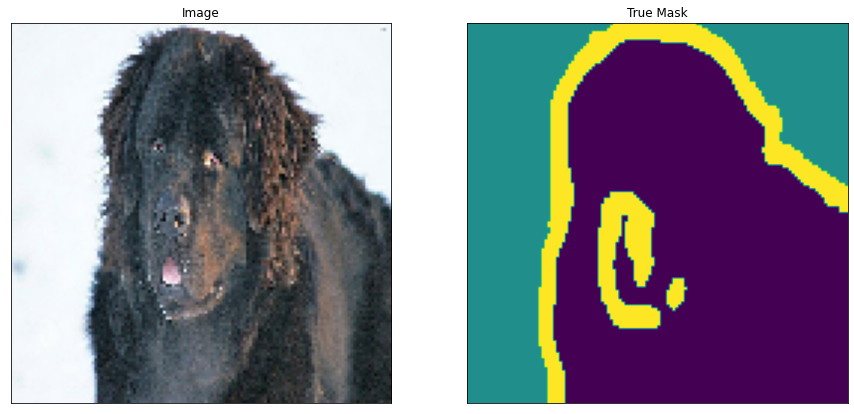

In [ ]:
# display an image from the train set
show_image_from_dataset(train)

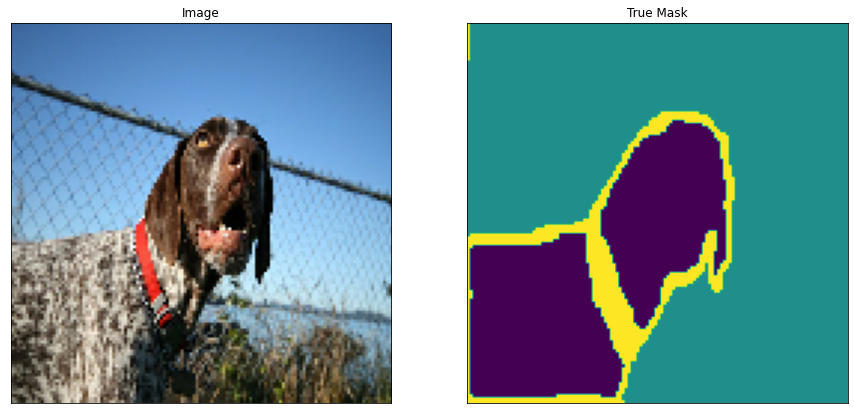

In [ ]:
# display an image from the test set
show_image_from_dataset(test)

## Defining the model


<img src='https://drive.google.com/uc?export=view&id=1BeQSKL2Eq6Fw9iRXsN1hgunY-CS2nH7V' alt='unet'>

A UNet consists of an encoder (downsampler) and decoder (upsampler) with a bottleneck in between. The gray arrows correspond to the skip connections that concatenate encoder block outputs to each stage of the decoder.

### Encoder

The encoder here will have repeating blocks. These encoder blocks will contain two Conv2D layers activated by ReLU, followed by a MaxPooling and Dropout layer. Each stage will have increasing number of filters and the dimensionality of the features will reduce because of the pooling layer.

<img src='https://drive.google.com/uc?export=view&id=1Gs9K3_8ZBn2_ntOtJL_-_ww4ZOgfyhrS' alt='unet'>

The encoder utilities will have three functions:

* `conv2d_block()` - to add two convolution layers and ReLU activations
* `encoder_block()` - to add pooling and dropout to the conv2d blocks. This function will return two values to take that into account (i.e. output of the conv block and the dropout)
* `encoder()` - to build the entire encoder. This will return the output of the last encoder block as well as the output of the previous conv blocks. These will be concatenated to the decoder blocks.

In [ ]:
# Encoder Utilities

# This function Adds 2 convolutional layers with the parameters passed to it
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  
  return x

# This function Adds two convolutional blocks and then perform down sampling on output of convolutions.
def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  
  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p

# This function defines the encoder or downsampling path.
def encoder(inputs):
  
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

### Bottleneck


A bottleneck follows the encoder block and is used to extract more features. This does not have a pooling layer so the dimensionality remains the same. You can use the `conv2d_block()` function defined earlier to implement this.

In [ ]:
# This function defines the bottleneck convolutions to extract more features before the upsampling layers.

def bottleneck(inputs):
  
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

### Decoder

Finally, we have the decoder which upsamples the features back to the original image size. At each upsampling level, you will take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block. This is summarized in the figure below.

<img src='https://drive.google.com/uc?export=view&id=1Ql5vdw6l88vxaHgk7VjcMc4vfyoWYx2w' alt='unet_decoder'>

In [ ]:
# Decoder Utilities

# defines the one decoder block of the UNet
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):

  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c

# Defines the decoder of the UNet chaining together 4 decoder blocks.
def decoder(inputs, convs, output_channels):
  
  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

### Putting it all together

You can finally build the UNet by chaining the encoder, bottleneck, and decoder. You will specify the number of output channels and in this particular set, that would be `3`. That is because there are three possible labels for each pixel: 'pet', 'background', and 'outline'.

In [ ]:
OUTPUT_CHANNELS = 3

# Defines the UNet by connecting the encoder, bottleneck and decoder
def unet():
  
  # specify the input shape
  inputs = tf.keras.layers.Input(shape=(128, 128,3,))

  # feed the inputs to the encoder
  encoder_output, convs = encoder(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output)

  # feed the bottleneck and encoder block outputs to the decoder
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)
  
  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

# instantiate the model
model = unet()

# see the resulting model architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 activation_36 (Activation)     (None, 128, 128, 64  0           ['conv2d_38[0][0]']              
                                )                                                           

## Compile and Train the model

Now, all that is left to do is to compile and train the model. The loss you will use is `sparse_categorical_crossentropy`. The reason is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class and `sparse_categorical_crossentropy` is the recommended loss for such a scenario. 

In [ ]:
# configure the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# configuring the training parameters and train the model

TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 15
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE

# this will take around 20 minutes to run
model_history = model.fit(training_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=testing_dataset)

Epoch 1/15
57/57 [==============================] - 97s 1s/step - loss: 1.0704 - accuracy: 0.5776 - val_loss: 0.8825 - val_accuracy: 0.5899
Epoch 2/15
57/57 [==============================] - 74s 1s/step - loss: 0.7720 - accuracy: 0.6797 - val_loss: 0.7524 - val_accuracy: 0.6894
Epoch 3/15
57/57 [==============================] - 66s 1s/step - loss: 0.6783 - accuracy: 0.7248 - val_loss: 0.6381 - val_accuracy: 0.7406
Epoch 4/15
57/57 [==============================] - 66s 1s/step - loss: 0.6124 - accuracy: 0.7535 - val_loss: 0.5744 - val_accuracy: 0.7683
Epoch 5/15
57/57 [==============================] - 66s 1s/step - loss: 0.5571 - accuracy: 0.7789 - val_loss: 0.5751 - val_accuracy: 0.7628
Epoch 6/15
57/57 [==============================] - 66s 1s/step - loss: 0.5223 - accuracy: 0.7942 - val_loss: 0.5233 - val_accuracy: 0.7953
Epoch 7/15
57/57 [==============================] - 66s 1s/step - loss: 0.4916 - accuracy: 0.8083 - val_loss: 0.4711 - val_accuracy: 0.8167
Epoch 8/15
57/57 [==

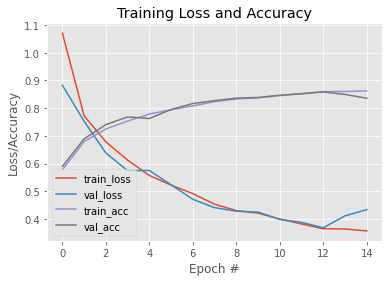

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), model_history.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), model_history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), model_history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), model_history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# saving the figure of accuracy and loss
plot_path = "plot.png"
plt.savefig(plot_path)

### Prediction

In [ ]:
# Unpacks the test dataset and returns the input images and segmentation masks
def get_test_image_and_annotation_arrays(NO_of_Batches):

  ds = testing_dataset.unbatch()
  ds = ds.batch(BATCH_SIZE*NO_of_Batches)
  
  images = []
  y_true_segments = []

  for image, annotation in ds.take(1).unbatch():
    y_true_segments.append(annotation.numpy())
    images.append(image.numpy())
  
  images = np.array(images)
  y_true_segments = np.array(y_true_segments)
  
  return images, y_true_segments
 

In [ ]:
# get the ground truth from the test set
y_true_images, y_true_segments = get_test_image_and_annotation_arrays(2)

In [ ]:
# Creates the segmentation mask by getting the channel with the highest probability.
def create_mask(pred_mask):
  
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(image, mask):
  
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

In [ ]:
# feed the test set to th emodel to get the predicted masks
results = model.predict(testing_dataset, steps=2)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

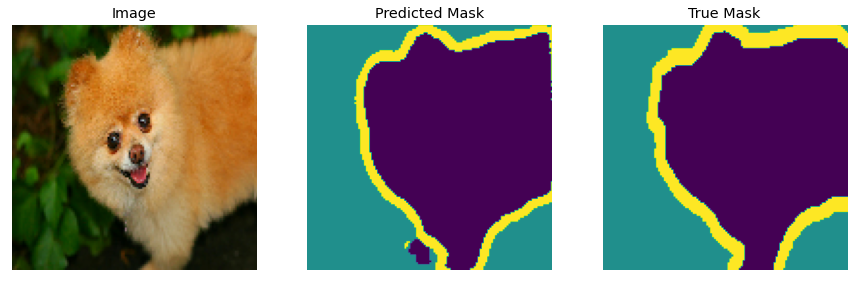

In [ ]:
# choosing random image from the dataset
random_image  = np.random.choice(128)

# Get the prediction mask
y_pred_mask = make_predictions(y_true_images[random_image], y_true_segments[random_image])
display([y_true_images[random_image], y_pred_mask, y_true_segments[random_image]], titles=["Image", "Predicted Mask", "True Mask"])

### Evaluating the model and Computing Metrics

The function below generates the IOU and dice score of the prediction and ground truth masks. it is given that:

$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$
<br>
$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$

A small smoothening factor is introduced in the denominators to prevent possible division by zero.

In [ ]:
def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001
  for i in range(3):
    
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

In [ ]:
# Computing the class wise metrics
iou_list, dice_score_list = class_wise_metrics(y_true_segments[random_image], y_pred_mask)  
metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

display_string_list = ["{}: IOU: {}  Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
display_string = "\n".join(display_string_list) 
print(display_string)

pet: IOU: 0.9559805364309375  Dice Score: 0.9774949383989037
background: IOU: 0.8986700444922894  Dice Score: 0.9466310882699874
outline: IOU: 0.6154558092760026  Dice Score: 0.7619593275223164


### We Can conclude that U-Net has much better results than FCN8.
